In [34]:
import mne
import scipy.io
import numpy as np
import matplotlib.pyplot as plt

### s43 예시

In [35]:
# mat file 불러오기
mat = scipy.io.loadmat("GIST_MI/s43.mat")

### Raw 객체로 변환

In [36]:
# info 매개변수 생성
eeg_ch_names = [
    "Fp1", "AF7", "AF3", "F1", "F3", "F5", "F7", "FT7", "FC5", "FC3", "FC1",
    "C1", "C3", "C5", "T7", "TP7", "CP5", "CP3", "CP1", "P1", "P3", "P5", "P7",
    "P9", "PO7", "PO3", "O1", "Iz", "Oz", "POz", "Pz", "CPz", "Fpz", "Fp2",
    "AF8", "AF4", "AFz", "Fz", "F2", "F4", "F6", "F8", "FT8", "FC6", "FC4",
    "FC2", "FCz", "Cz", "C2", "C4", "C6", "T8", "TP8", "CP6", "CP4", "CP2",
    "P2", "P4", "P6", "P8", "P10", "PO8", "PO4", "O2",
]
emg_ch_names = ["EMG1", "EMG2", "EMG3", "EMG4"]
ch_names = eeg_ch_names + emg_ch_names + ["Stim"]
ch_types = ["eeg"] * 64 + ["emg"] * 4 + ["stim"]
srate = mat['eeg'][0]['srate'][0][0]

# info 생성
info = mne.create_info(ch_names=ch_names, sfreq=srate, ch_types=ch_types)

# Stim channel 붙이기
left = np.vstack((mat['eeg'][0]['imagery_left'][0], mat['eeg'][0]['imagery_event'][0]))
right = np.vstack((mat['eeg'][0]['imagery_right'][0], mat['eeg'][0]['imagery_event'][0]))

# Raw 생성
lr = mne.io.RawArray(left, info=info)
rr = mne.io.RawArray(right, info=info)
raw = [lr, rr]

Creating RawArray with float64 data, n_channels=69, n_times=358400
    Range : 0 ... 358399 =      0.000 ...   699.998 secs
Ready.
Creating RawArray with float64 data, n_channels=69, n_times=358400
    Range : 0 ... 358399 =      0.000 ...   699.998 secs
Ready.


In [37]:
LEFT = 0
RIGHT = 1

### Rereference

In [38]:
mne.set_eeg_reference(raw[LEFT], ch_type='eeg')
mne.set_eeg_reference(raw[RIGHT], ch_type='eeg')

Applying average reference.
Applying a custom ('EEG',) reference.
Applying average reference.
Applying a custom ('EEG',) reference.


(<RawArray | 69 x 358400 (700.0 s), ~188.7 MB, data loaded>,
 array([-181914.15997314, -181965.50762939, -182067.99591064, ...,
        -262159.56994629, -262121.27697754, -262234.16369629]))

### -2s ~ 5s Epoching

In [39]:
# events 생성
le = mne.find_events(raw[LEFT], stim_channel='Stim')
re = mne.find_events(raw[RIGHT], stim_channel='Stim')
events = [le, re]

# Epochs 생성
le = mne.Epochs(raw[LEFT], events[LEFT], tmin=-2, tmax=5, baseline=(-0.5, 0))
re = mne.Epochs(raw[RIGHT], events[RIGHT], tmin=-2, tmax=5, baseline=(-0.5, 0))
epochs = [le, re]

100 events found
Event IDs: [1]
100 events found
Event IDs: [1]
Not setting metadata
100 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
100 matching events found
Applying baseline correction (mode: mean)
0 projection items activated


In [40]:
# Pick C3, C4
epochs[LEFT].load_data()
epochs[RIGHT].load_data()

epochs[LEFT].pick(picks=['C3', 'C4'])
epochs[RIGHT].pick(picks=['C3', 'C4'])

Using data from preloaded Raw for 100 events and 3585 original time points ...
1 bad epochs dropped
Using data from preloaded Raw for 100 events and 3585 original time points ...
1 bad epochs dropped


Number of events,99
Events,1: 99
Time range,-2.000 – 5.000 s
Baseline,-0.500 – 0.000 s


In [41]:
C3 = 0
C4 = 1

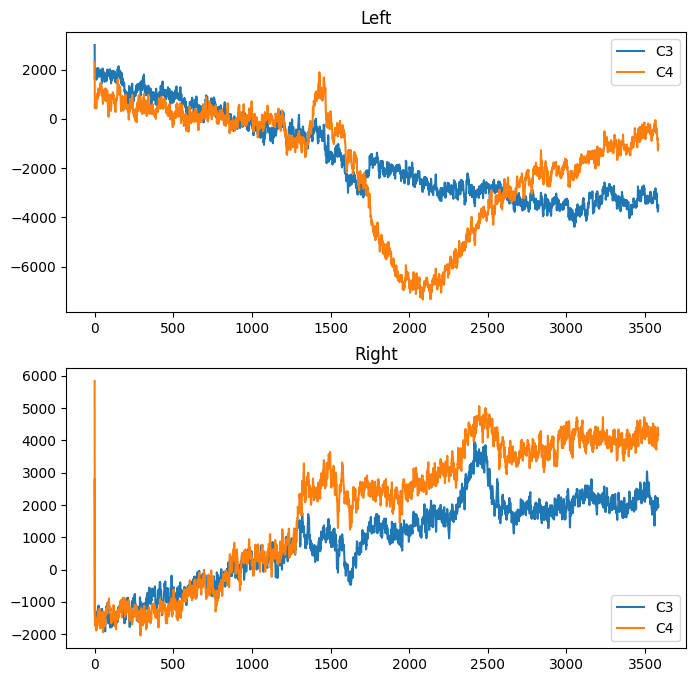

In [42]:
# 예시 데이터 plot
data = [epochs[LEFT].get_data(), epochs[RIGHT].get_data()]

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 8))

axes[0].plot(data[LEFT][0][C3], label='C3')
axes[0].plot(data[LEFT][0][C4], label='C4')
axes[0].set_title("Left")
axes[0].legend()

axes[1].plot(data[RIGHT][0][C3], label='C3')
axes[1].plot(data[RIGHT][0][C4], label='C4')
axes[1].set_title("Right")
axes[1].legend()

plt.show()

#### Question
* Epochs을 생성할 때 ```tmin=-2```, ```tmax=5```로 설정했는데 왜 결과는 (0, 3585)인가?
    * ! 3585를 ```sampling rate```로 나누면 $3585/512 \approx 7.00$ -> x축은 데이터 갯수를 의미!

### Bandpass Filtering(alpha band: 8Hz ~ 13Hz)

In [43]:
raw[LEFT].filter(l_freq=8, h_freq=13)
raw[RIGHT].filter(l_freq=9, h_freq=13)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 845 samples (1.650 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 9 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 9.00
- Lower transition bandwidth: 2.25 Hz (-6 dB cutoff frequency: 7.88 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 751 samples (1.467 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


<RawArray | 69 x 358400 (700.0 s), ~188.7 MB, data loaded>

### -1s ~ 3s Epoching

Not setting metadata
100 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
100 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 100 events and 2049 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 100 events and 2049 original time points ...
0 bad epochs dropped


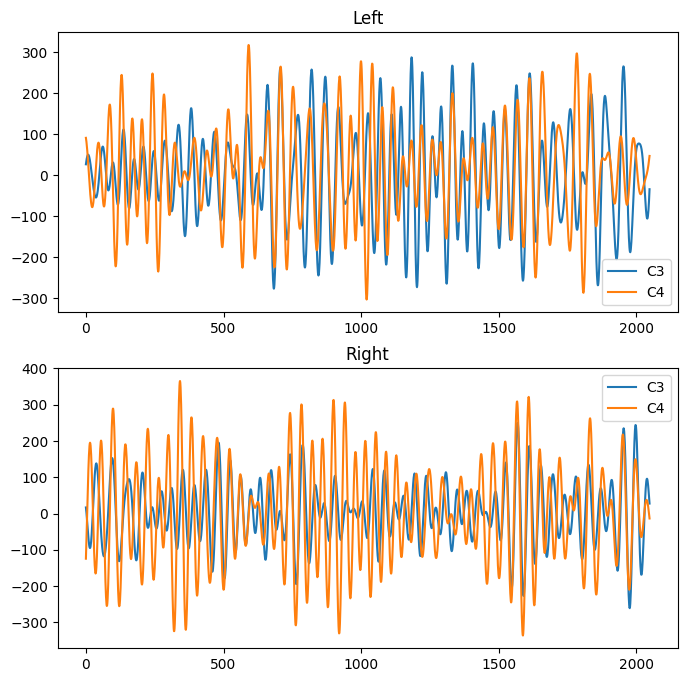

In [44]:
# Epochs 생성
le = mne.Epochs(raw[LEFT], events[LEFT], tmin=-1, tmax=3, baseline=(-0.5, 0))
re = mne.Epochs(raw[RIGHT], events[RIGHT], tmin=-1, tmax=3, baseline=(-0.5, 0))
epochs = [le, re]

# Pick C3, C4
epochs[LEFT].load_data()
epochs[RIGHT].load_data()

epochs[LEFT].pick(picks=['C3', 'C4'])
epochs[RIGHT].pick(picks=['C3', 'C4'])

# 예시 데이터 plot
data = [epochs[LEFT].get_data(), epochs[RIGHT].get_data()]

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 8))

axes[0].plot(data[LEFT][0][C3], label='C3')
axes[0].plot(data[LEFT][0][C4], label='C4')
axes[0].set_title("Left")
axes[0].legend()

axes[1].plot(data[RIGHT][0][C3], label='C3')
axes[1].plot(data[RIGHT][0][C4], label='C4')
axes[1].set_title("Right")
axes[1].legend()

plt.show()

### Question
* Epochs을 생성할 때 ```tmin=-1```, ```tmax=3```로 설정했는데 왜 결과는 (0, 2049)인가?

### abs()

In [45]:
# epoch의 데이터 가져오기
data = [epochs[LEFT].get_data(), epochs[RIGHT].get_data()]
data[LEFT].shape

(100, 2, 2049)

In [46]:
# abs()
data = [np.abs(data[LEFT]), np.abs(data[RIGHT])]

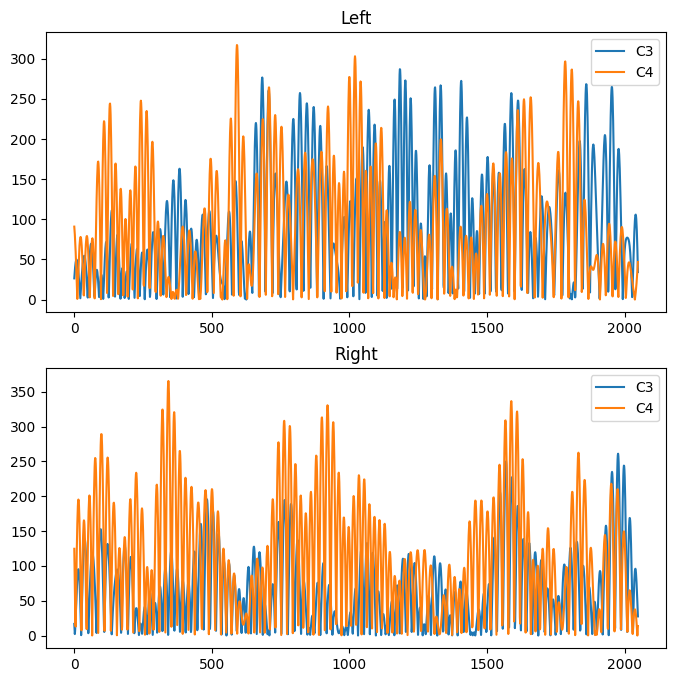

In [47]:
# 예시 데이터 plot
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 8))

axes[0].plot(data[LEFT][0][C3], label='C3')
axes[0].plot(data[LEFT][0][C4], label='C4')
axes[0].set_title("Left")
axes[0].legend()

axes[1].plot(data[RIGHT][0][C3], label='C3')
axes[1].plot(data[RIGHT][0][C4], label='C4')
axes[1].set_title("Right")
axes[1].legend()

plt.show()

### Mean of Left, Right MI

In [48]:
data = [np.mean(data[LEFT], axis=0), np.mean(data[RIGHT], axis=0)]

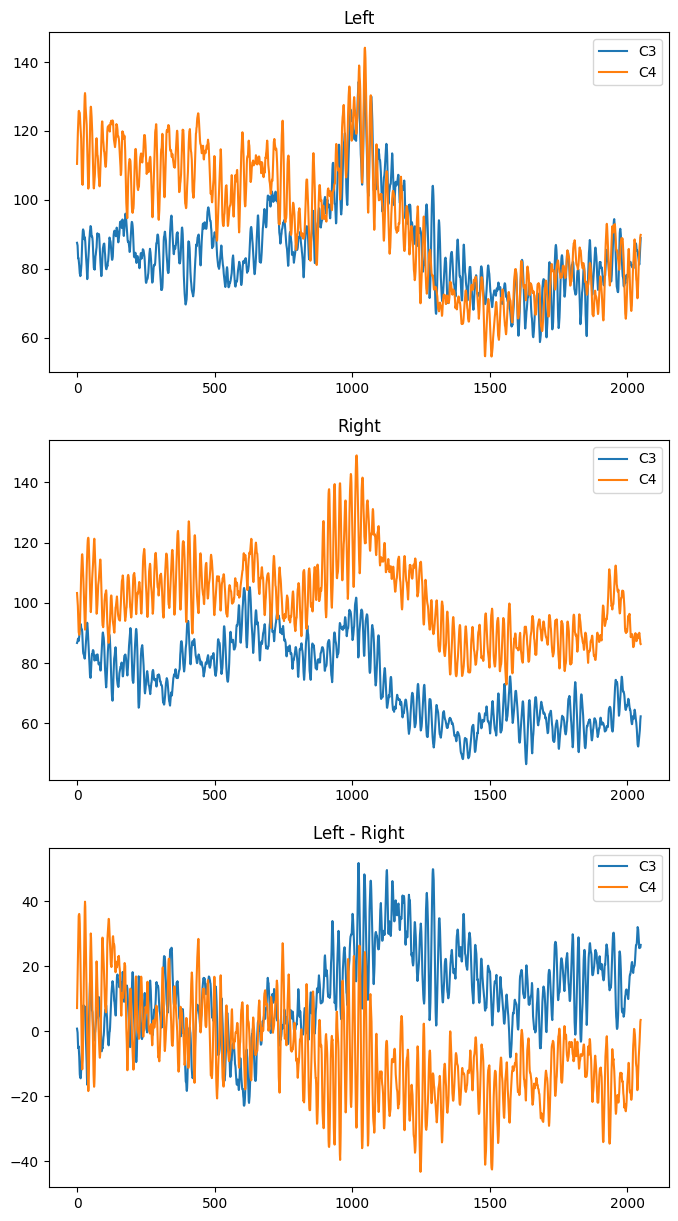

In [49]:
# 예시 데이터 plot
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 15))

axes[0].plot(data[LEFT][C3], label='C3')
axes[0].plot(data[LEFT][C4], label='C4')
axes[0].set_title("Left")
axes[0].legend()

axes[1].plot(data[RIGHT][C3], label='C3')
axes[1].plot(data[RIGHT][C4], label='C4')
axes[1].set_title("Right")
axes[1].legend()

axes[2].plot(data[LEFT][C3] - data[RIGHT][C3], label='C3')
axes[2].plot(data[LEFT][C4] - data[RIGHT][C4], label='C4')
axes[2].set_title("Left - Right")
axes[2].legend()

plt.show()